In [1]:
import os
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langgraph.graph import END, MessageGraph
from langchain.globals import set_debug, set_verbose

load_dotenv()

from langchain.globals import set_debug
from langchain.globals import set_verbose

set_verbose(False)
set_debug(False)

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY") 
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
langchain_endpoint = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_PROJECT"] = "code_assistant"


from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)


In [4]:
llm =  ChatGroq(temperature=1, model_name="llama3-70b-8192", api_key=groq_api_key)

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."



code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain_oai.invoke({"context":concatenated_content,"messages":[("user",question)]})

/opt/conda/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The method `ChatGroq.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [7]:
solution = code_gen_chain.invoke({"context":concatenated_content,"messages":[("user",question)]})

In [11]:
print(dir(solution))



['Config', '__abstractmethods__', '__annotations__', '__class__', '__class_vars__', '__config__', '__custom_root_type__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__exclude_fields__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_validators__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__include_fields__', '__init__', '__init_subclass__', '__iter__', '__json_encoder__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__post_root_validators__', '__pre_root_validators__', '__pretty__', '__private_attributes__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_args__', '__repr_name__', '__repr_str__', '__rich_repr__', '__schema_cache__', '__setattr__', '__setstate__', '__signature__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__try_update_forward_refs__', '__validators__', '_abc_impl', '_calculate_keys', '_copy_and_set_values', '_decompose_class', '_enforce_dict_if_root', '_get_value', '_init_private_attribute

In [12]:
from typing import Dict, TypedDict, List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [13]:
from operator import itemgetter
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection
    reflection_message = [
        (
            "user",
            """You tried to solve this problem and failed a unit test. Reflect on this failure
                                    given the provided documentation. Write a few key suggestions based on the 
                                    documentation to avoid making this mistake again.""",
        )
    ]

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [14]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

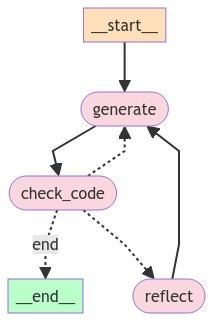

In [16]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass



In [17]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
app.invoke({"messages": [("user", question)], "iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---


{'error': 'yes',
 'messages': [('user',
   'How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?'),
  ('assistant',
   'Description of the problem and approach \n Imports: import required libraries \n Code: your_code_string_here'),
  ('user',
   'Your solution failed the import test: invalid syntax (<string>, line 1)'),
  ('user',
   'Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:'),
  ('assistant',
   'Description of the problem and approach \n Imports: import required libraries \n Code: your_code_string_here'),
  ('user',
   'Your solution failed the import test: invalid syntax (<string>, line 1)'),
  ('user',
   'Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:'),
  ('assistant',
   'Description of the problem and approach \n Imports:  \n Code: your_code_string_here'),
  ('user',
   "Your solution failed the code execution test: 